# Land-Use-Land-Cover Prediction for Slovenia
This notebook shows the steps towards constructing a machine learning pipeline for **predicting the land use and land cover for the region of Republic of Slovenia**. We will use satellite images obtained by **ESA’s Sentinel-2** to train a model and use it for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

In [1]:
# Load the autoreload extension to automatically reload modules when files on disk are updated
%load_ext autoreload
# it will automatically be reloaded without the need to restart the kernel.
%autoreload 2

import os
from dotenv import load_dotenv
import sys

In [2]:
# Load environment variables from the .env file in the current directory
load_dotenv()
# Fetch the project directory path from the .env file using the variable 'PROJECT_DIR'
PROJECT_PATH = os.getenv('PROJECT_PATH')
DATASETS_PATH = os.getenv('DATASETS_PATH')

In [3]:
import datetime
import itertools
# Built-in modules
import os
# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum
np.random.seed(42)
import geopandas as gpd
import joblib
# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask
from sentinelhub import SHConfig

## 1. Define thge Area-of-interest (AOI)
- A geographical shape of Slovenia was taken from Natural Earth database and a buffer of 500 m was applied. The shape is available in repository: example_data/svn_border.geojson
- Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
- Split it into smaller, manageable, non-overlapping rectangular tiles
- Run classification on a selected 5x5 area

In [4]:
SENTINEL_HUB_CLIENT_ID = os.getenv('SENTINEL_HUB_CLIENT_ID')
SENTINEL_HUB_CLIENT_SECRET = os.getenv('SENTINEL_HUB_CLIENT_SECRET')

config = SHConfig()
config.sh_client_id = SENTINEL_HUB_CLIENT_ID
config.sh_client_secret = SENTINEL_HUB_CLIENT_SECRET

In [5]:
# Folder where data for running the notebook is stored
DATA_FOLDER = os.path.join(DATASETS_PATH, "example_data")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(DATASETS_PATH, "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(DATASETS_PATH, "eopatches_sampled")
RESULTS_FOLDER = os.path.join(DATASETS_PATH, "results")

In [6]:
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

In [7]:
# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "svn_border.geojson"))

In [8]:
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

In [9]:
# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

(361423.7915523445, 628926.2196410941, 5021668.642233825, 5199411.522088733)

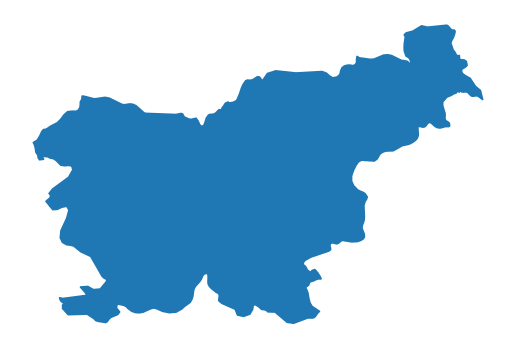

In [10]:
# Plot country
country.plot()
plt.axis("off")

In [11]:
# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

Dimension of the area is 243184 x 161584 m2


## 2. Split to smaller tiles and choose a 5x5 area
The splitting choice depends on the available resources of your computer. An EOPatch with a size of has around 500 x 500 pixels at 10 meter resolution has a size ob about ~1 GB.

In [12]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

In [13]:
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

In [14]:
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

In [15]:
bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

In [16]:
# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patch_ids.append(idx)

In [17]:
# Check if final size is 5x5
if len(patch_ids) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

In [18]:
# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(5, 5))).ravel()

In [19]:
# Save to shapefile
shapefile_name = "grid_slovenia_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

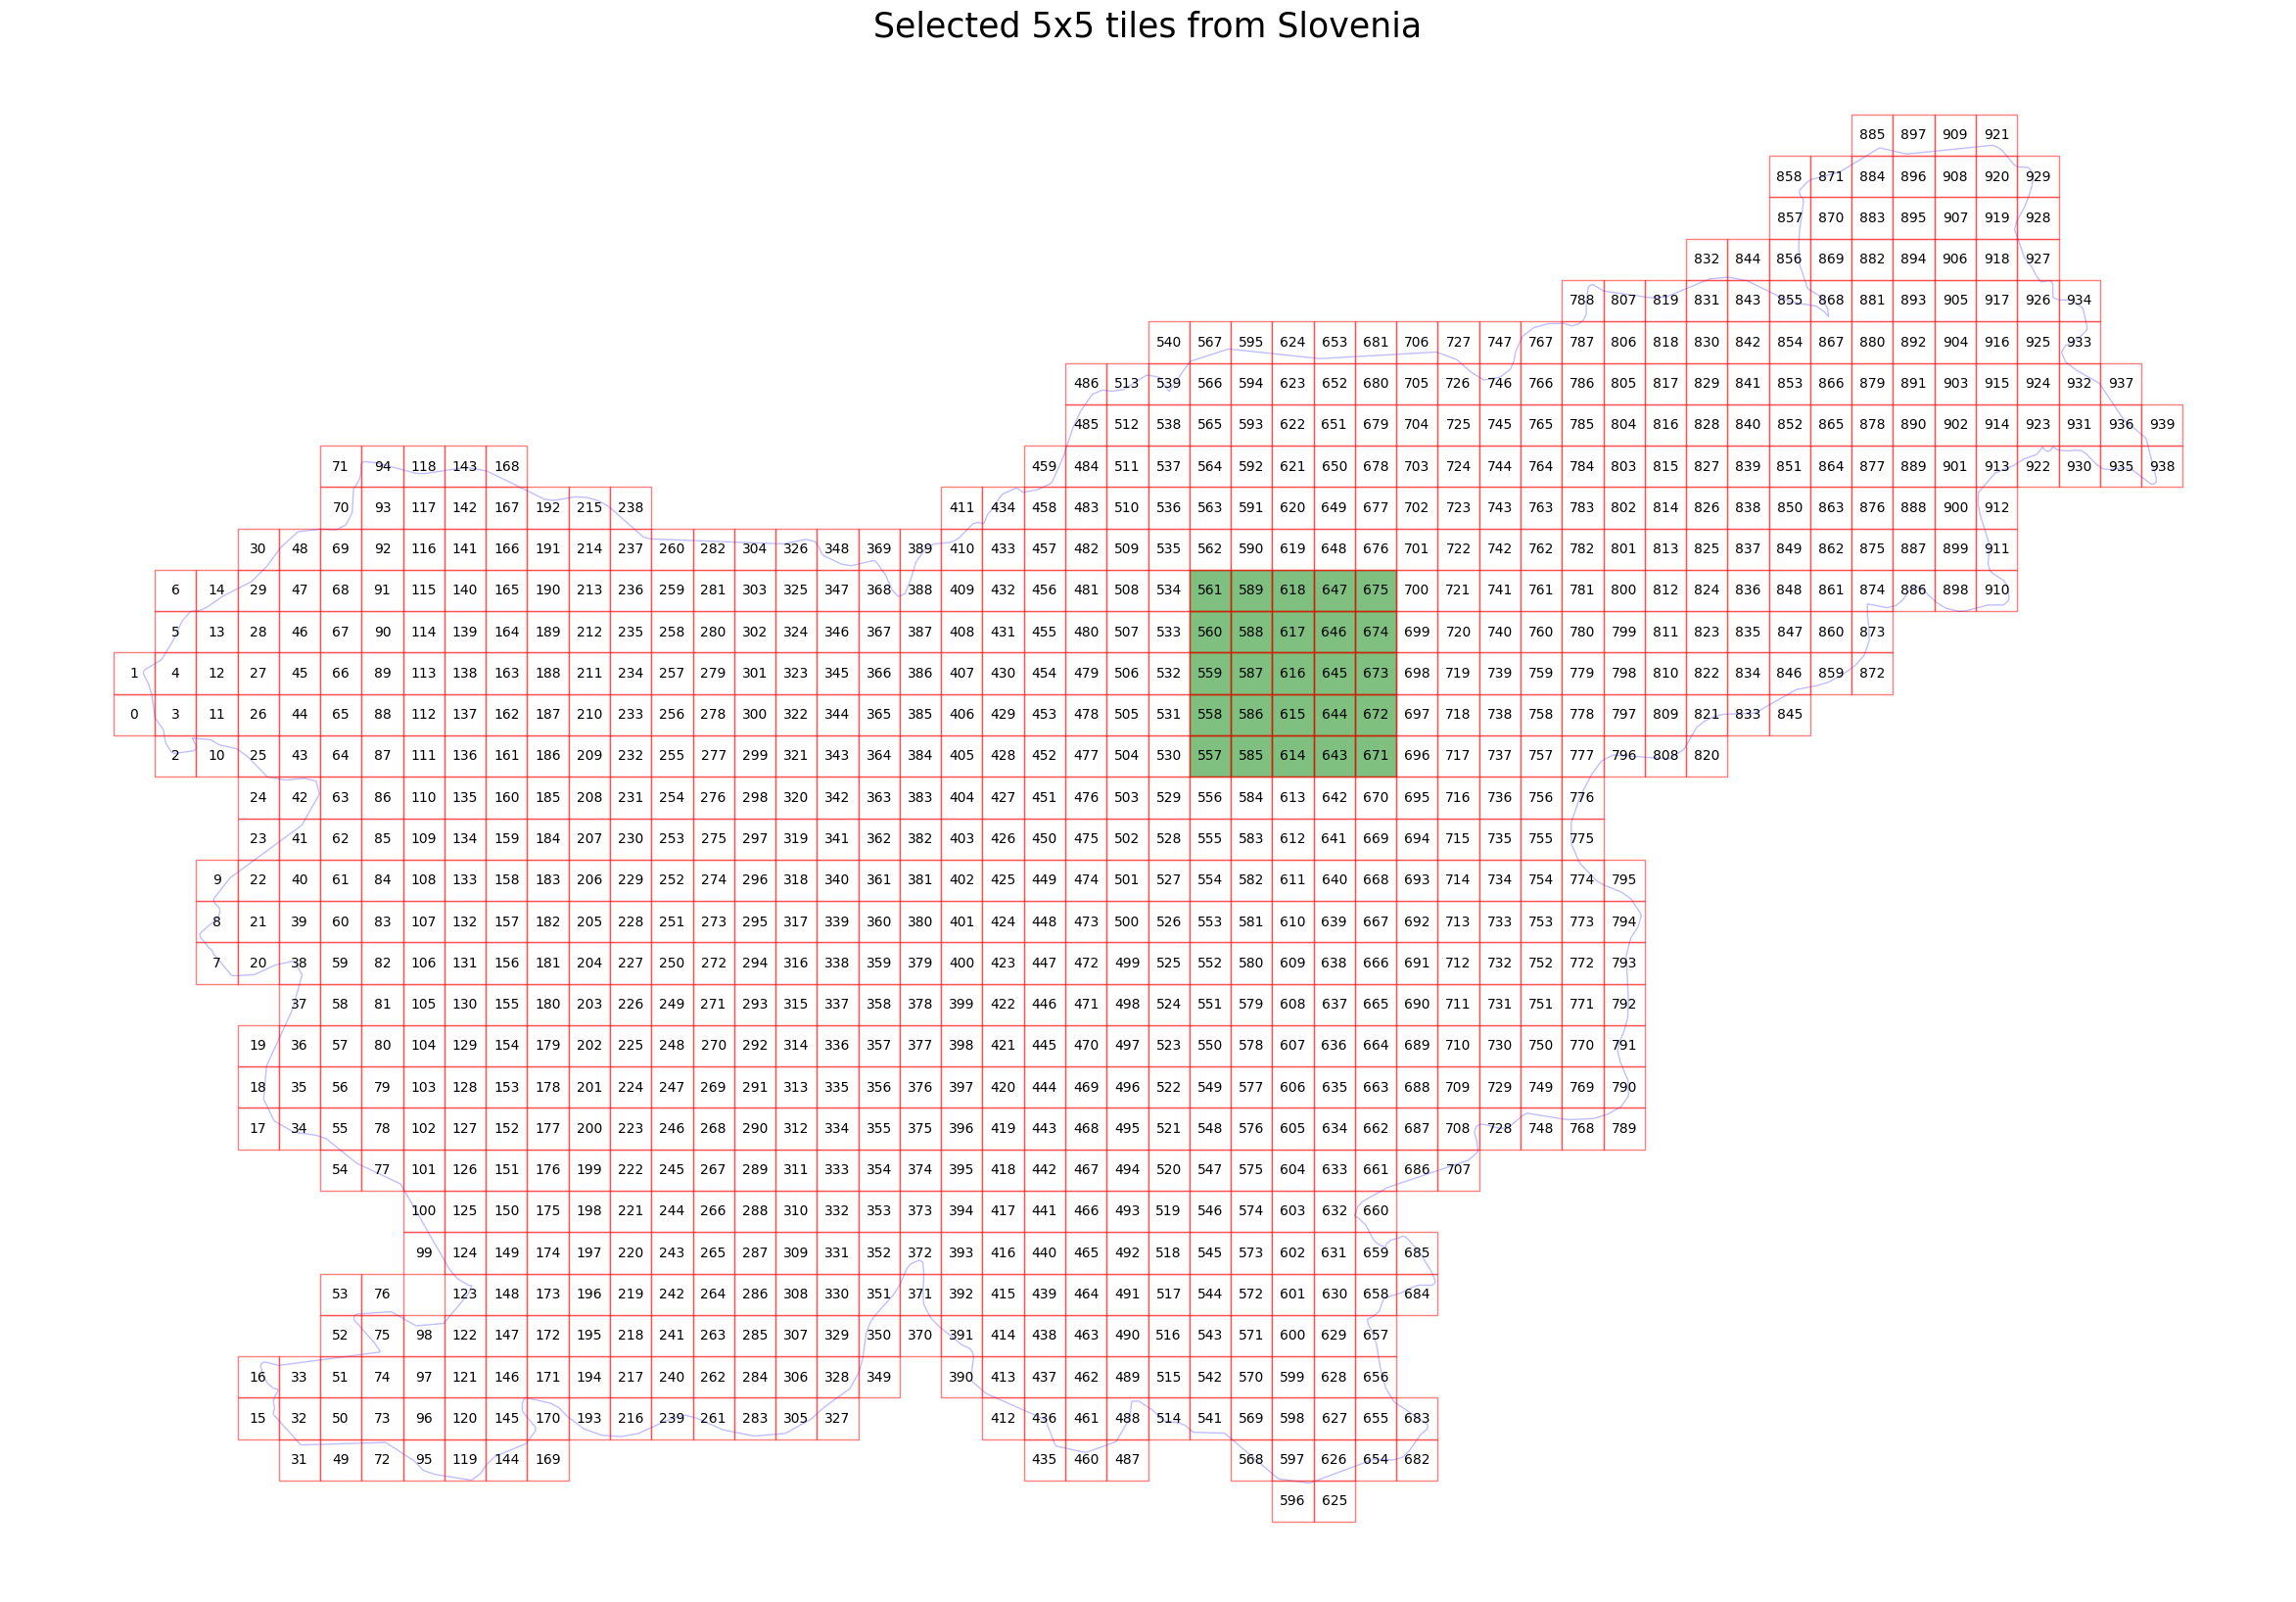

In [20]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title("Selected 5x5 tiles from Slovenia", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

## 3. Fill EOPatches with data

Now it’s time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

- L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.
- SentinelHub’s cloud mask

Additionally, we will add:
- Calculated NDVI, NDWI, and NDBI information
- A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
    - IS_DATA == True
    - CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates NO_DATA)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

#### 3.1 Define some needed custom EOTasks

In [21]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

#### 3.2 Define the workflow tasks

In [22]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
    config=config
)

In [23]:
# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)

In [24]:
# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

#### 3.3 Define a land cover enum class for ease of use below.

In [25]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]

In [26]:
# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)

#### 3.4 SentinelHub

The main point of this task is to **create a raster mask from the vector polygons and add it to the eopatch**. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task VectorToRaster from the eolearn.geometry package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Slovenia, you can use the provided partial dataset for this example, or download the full dataset (if you want to upscale the project) from our bucket. The datasets have already been pre-processed for the purposes of the example.

In [27]:
import requests

In [28]:
land_use_ref_path = os.path.join(DATA_FOLDER, "land_use_10class_reference_slovenia_partial.gpkg")
land_use_ref_path

'/home/nicksson/Git/agro-serasa/data/example_data/land_use_10class_reference_slovenia_partial.gpkg'

In [29]:
%%time
url = "http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/land_use_10class_reference_slovenia_partial.gpkg"
r = requests.get(url, allow_redirects=True)
with open(land_use_ref_path, "wb") as gpkg:
    gpkg.write(r.content)

CPU times: user 58.1 ms, sys: 102 ms, total: 160 ms
Wall time: 14.7 s


In [30]:
gpkg

<_io.BufferedWriter name='/home/nicksson/Git/agro-serasa/data/example_data/land_use_10class_reference_slovenia_partial.gpkg'>

In [31]:
vector_feature = FeatureType.VECTOR_TIMELESS, "LULC_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LULC"),
    values_column="lulcid",
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

## 4. Define the workflow

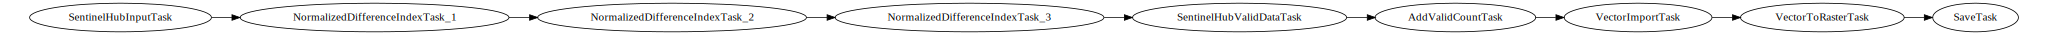

In [32]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [33]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"EOPATCH_FOLDER": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/25 [00:00<?, ?it/s]

/home/nicksson/Git/agro-serasa/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/nicksson/Git/agro-serasa/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/nicksson/Git/agro-serasa/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/nicksson/Git/agro-serasa/.venv/lib/python3.11/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/nicksson/Git/agro-serasa/.venv/lib/python3.11/site-packages/sentinelhub/downlo

RuntimeError: Execution failed EOPatches with IDs:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
For more info check report at /home/nicksson/Git/agro-serasa/notebooks/eoexecution-report-2024_09_22-12_31_52/report.html

In [34]:
EOPATCH_FOLDER

'/home/nicksson/Git/agro-serasa/data/eopatches'